In [1]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
import pandas as pd
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/diegogomez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/diegogomez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import the Dataset

En este paso se importan los dos archivos de datos desde la carpeta `./data`.
Luego se crea una nueva columna en cada Dataframe que representa el documento completo
(Titulo + contenido). Se le hace `drop` al resto de columnas.
El arreglo `targert` se construye a partir de los archivos anteriores, la idea es que sea un arreglo
de dimensión (n,1) donde n es la suma de el tamaño de los documentos anteriores. Además, los primeros k valores
se marcarán con 1, donde k es el tamaño de los datos de noticias reales, el resto son ceros representando las falsas.


In [2]:
datos_true = pd.read_csv('../data/pos/True.csv')
datos_false = pd.read_csv('../data/neg/Fake.csv')

datos_true['documento'] = datos_true['title']+ datos_true['text']
datos_false['documento'] = datos_false['title'] + datos_false['text']

# Creación de arreglo Target
target_true = np.ones(len(datos_true['documento']))
target_false = np.zeros(len(datos_false['documento']))
target = np.concatenate((target_true, target_false))

# Descartar columnas
datos_true.drop(columns=['title', 'text', 'subject', 'date'], axis=1, inplace=True)
datos_false.drop(columns=['title', 'text', 'subject', 'date'], axis=1, inplace=True)

print(len(target))

44898


## Preprocesamiento

Se le aplica a cada Dataframe un filtrado de caracteres con poco valor para el modelo.

In [3]:
stemmer = WordNetLemmatizer()
def regex_filter(text):
        # Remove all the special characters
    document = re.sub(r'\W', ' ', text)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    return document

datos_true['documento'].apply(regex_filter)
datos_false['documento'].apply(regex_filter)

print(datos_true['documento'])

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
21412    'Fully committed' NATO backs new U.S. approach...
21413    LexisNexis withdrew two products from Chinese ...
21414    Minsk cultural hub becomes haven from authorit...
21415    Vatican upbeat on possibility of Pope Francis ...
21416    Indonesia to buy $1.14 billion worth of Russia...
Name: documento, Length: 21417, dtype: object


## Text to number (Bag of words)
Se pasan las columnas con los datos relevantes a una lista y se concatenan
 con la de noticias ciertas primero (súper importante por cómo se contruyó el arreglo `Target`).
Luego se vectoriza la información de texto que pasamos. Los parámetros representan lo siguiente:
`max_feature` es el límite de palabras a vectorizas, es decir, solo se tendrán en cuenta las 2000 palabras
más frecuentes en este caso. `min_df` es la cantidad mínima de datos que debe contener una palabra para que
se tenga en cuenta. `max_df` es el porcentaje másximo de datos que pueden contener una palabra para que se tenga en cuenta.
En este caso descartamos las palabras que aparezcan en más del 70% de datos. `Stop word` es el diccionario
para filtrar palabras vacías.

In [4]:
documents = datos_true['documento'].to_list() + datos_false['documento'].to_list()
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()


## Análisis de ocurrencias

Se hizo un pequeño análisis de los datos de frecuencias de palabras para ver cómo
 se comportaban estas en las noticias de nuestra fuente de datos

In [81]:
vectorizer_verdaderas = CountVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
vectorizer_falsas = CountVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))

# Buscar occurencias
freq_T = vectorizer_verdaderas.fit_transform(datos_true['documento'].to_list())
freq_F = vectorizer_falsas.fit_transform(datos_false['documento'].to_list())

# sumar ocurrencias
freq_T = np.asarray(freq_T.sum(axis=0)).reshape(2000)
freq_F = np.asarray(freq_F.sum(axis=0)).reshape(2000)

dict_T = vectorizer_verdaderas.vocabulary_
dict_F = vectorizer_falsas.vocabulary_

#Se le asigna la frecuencia a cada palabra
dict_T = {key: freq_T[dict_T[key]] for key in dict_T.keys()}
dict_F = {key: freq_F[dict_F[key]] for key in dict_F.keys()}

# #Ordenar
dict_T = {dict_T: v for dict_T, v in sorted(dict_T.items(), key=lambda item: item[1], reverse=True)}
dict_F = {dict_F: v for dict_F, v in sorted(dict_F.items(), key=lambda item: item[1], reverse=True)}

# #Obtener 20 palabras más frecuentes

dict_T = {k: dict_T[k] for k in list(dict_T)[:20]}
dict_F = {k: dict_F[k] for k in list(dict_F)[:20]}

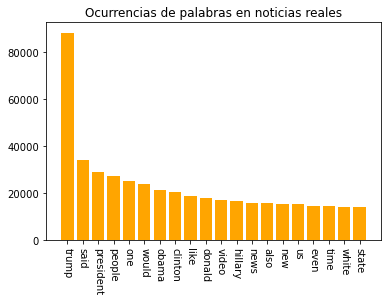

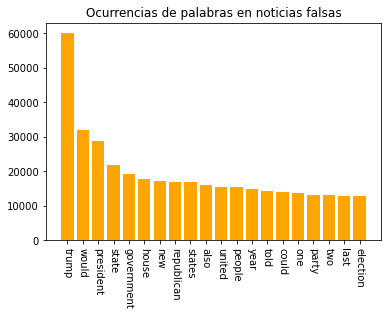

In [82]:
#Graficar

plt.bar(dict_F.keys(), dict_F.values(), width=0.8,color='orange')
plt.title('Ocurrencias de palabras en noticias reales')
plt.xticks(rotation=270)
plt.show()

plt.bar(dict_T.keys(), dict_T.values(), width=0.8,color='orange')
plt.title('Ocurrencias de palabras en noticias falsas')
plt.xticks(rotation=270)
plt.show()

## Text to number (TFIDF)

Esta tranformación es similar a la hecha en Bag of Words pero también tiene en cuenta el peso relativo
que tiene una palabra para la frase en donde se encuentra. Esto es, divida la frecuencia absoluta
encontrada con Bag of Words por el número de palabras totales del documento

In [5]:
tfidfconverter = TfidfTransformer()
X_tfidf = tfidfconverter.fit_transform(X).toarray()

In [84]:
print(X_tfidf.shape)

(44898, 2000)


El resultado es una matríz donde cada fila tiene 2000 entradas (1 por palabra encontrada) y el número de filas es
igual al número de datos (Noticias verdaderas + noticias falsas)

## Training and Testing Sets
Divide el conjunto con los datos `X`y la variable `target`. `test_size` representa el tamaño del set de prueba.
Hace este proceso de froma equivalente para los datos sacados con TFIDF

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=10)

In [6]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, target, test_size=0.3, random_state=10)

In [9]:
print(X_train.shape)

(31428, 2000)


## Training Text Classification Model
Aplicación del algoritmo deseado, en este caso un RandomForest

### Entrenamiento del algoritmo para la bolsa de palabras

In [6]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

### Entrenamiento del algoritmo para TFIDF

In [10]:
classifier_tfidf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
classifier_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = classifier_tfidf.predict(X_test_tfidf)

## Evaluación de Bolsa de palabras

In [7]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))


[[7043   13]
 [   4 6410]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7056
         1.0       1.00      1.00      1.00      6414

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

0.9987379361544172


### Evaluación de TFIDF

In [12]:
print(confusion_matrix(y_test_tfidf,y_pred_tfidf))
print(classification_report(y_test_tfidf,y_pred_tfidf))
print(accuracy_score(y_test_tfidf, y_pred_tfidf))


[[7043   13]
 [   7 6407]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7056
         1.0       1.00      1.00      1.00      6414

    accuracy                           1.00     13470
   macro avg       1.00      1.00      1.00     13470
weighted avg       1.00      1.00      1.00     13470

0.9985152190051967


### Aplicación de KNN
Además de usar Random Forest, se aplicó KNN para ver cómo se comportaría
un algoritmo más sencillo con nuestros datos.

#### Cross Validation
Primero hizo una validación cruzada para encontrar un valor óptimo para K. Esta validación
la hicimos entre k=3 y k=6 para encontrar el parámetro que mejor rendimiento tuviese.
Como medida usamos la precisión de cada iteración.


In [ ]:
accuracy = []
for k in range(3 , 7):
    #Explain the logic behind the selection of 'init' & 'algorithm' arguments
    knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(3, 7) , accuracy , 'o')
plt.plot(np.arange(3, 7) , accuracy , '-' , alpha = 0.5)
plt.xlabel('K - Cantidad de vecinos') , plt.ylabel('Precisión')
plt.show()

## Ejecución con K=3

In [8]:
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

## Evaluación de KNN


In [9]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[6058  998]
 [1471 4943]]
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      7056
         1.0       0.83      0.77      0.80      6414

    accuracy                           0.82     13470
   macro avg       0.82      0.81      0.82     13470
weighted avg       0.82      0.82      0.82     13470

0.8167037861915367


## Saving Model

In [ ]:
with open('RF_classifier_n_5000', 'wb') as picklefile:
    pickle.dump(classifier,picklefile)

In [ ]:
with open('../RF_classifier_n_5000', 'rb') as training_model:
    model = pickle.load(training_model)
